In [1]:
import numpy as np
import sep

In [2]:
# additonal setup for reading the test image and displaying plots
import astropy
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [3]:
# read image into standard 2-d numpy array
data = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

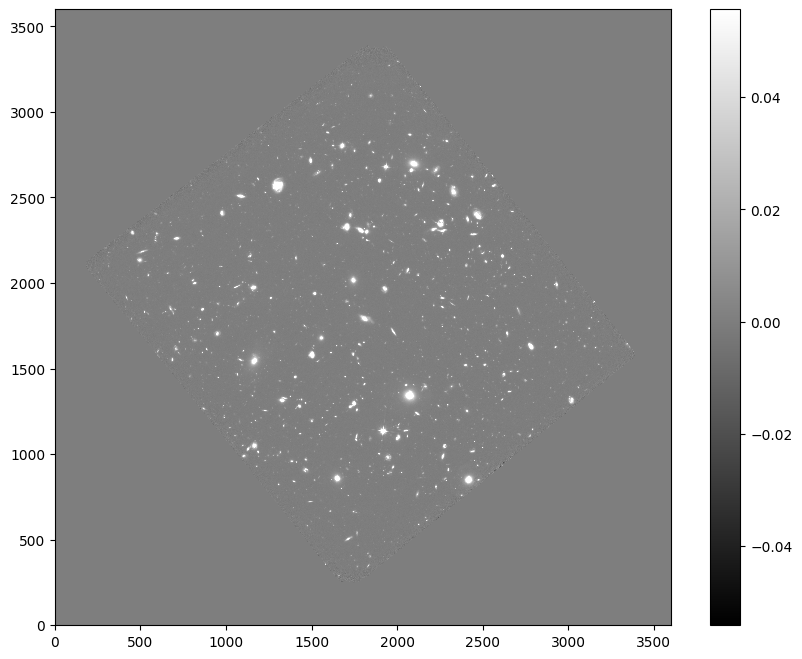

In [4]:
#show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

#plt.savefig("final-1.png", bbox_inches="tight", facecolor="white")

In [5]:
data = data.byteswap(inplace=True).newbyteorder()

In [6]:
#measure a spatially varying background on the image
bkg = sep.Background(data)

In [7]:
#various options for controlling the box size used in estimating the background and mask pixels
bkg = sep.Background(data, bw=64, bh=64, fw=3, fh=3)

In [8]:
#get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [9]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) #equivalent to above

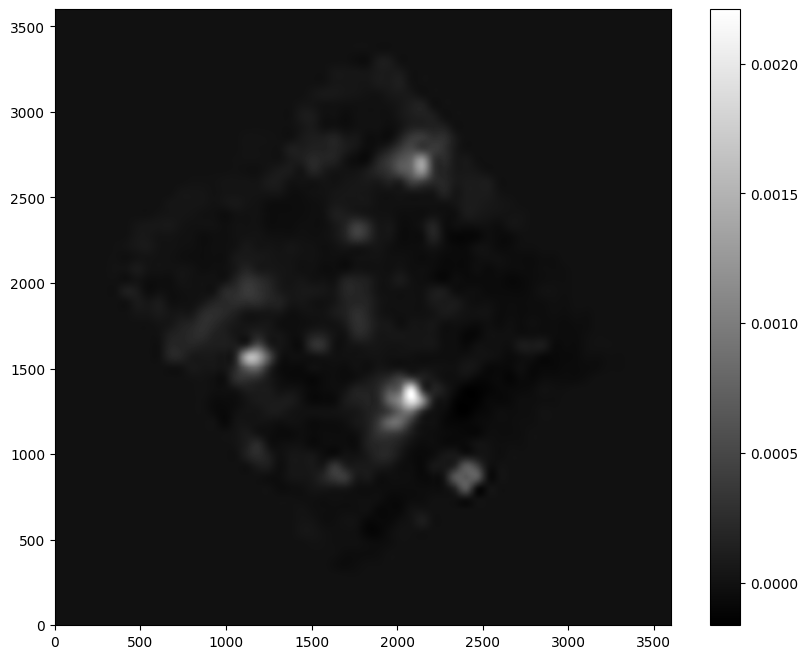

In [10]:
#show background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

#plt.savefig("final-2.png", bbox_inches="tight", facecolor="white")

In [11]:
#evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

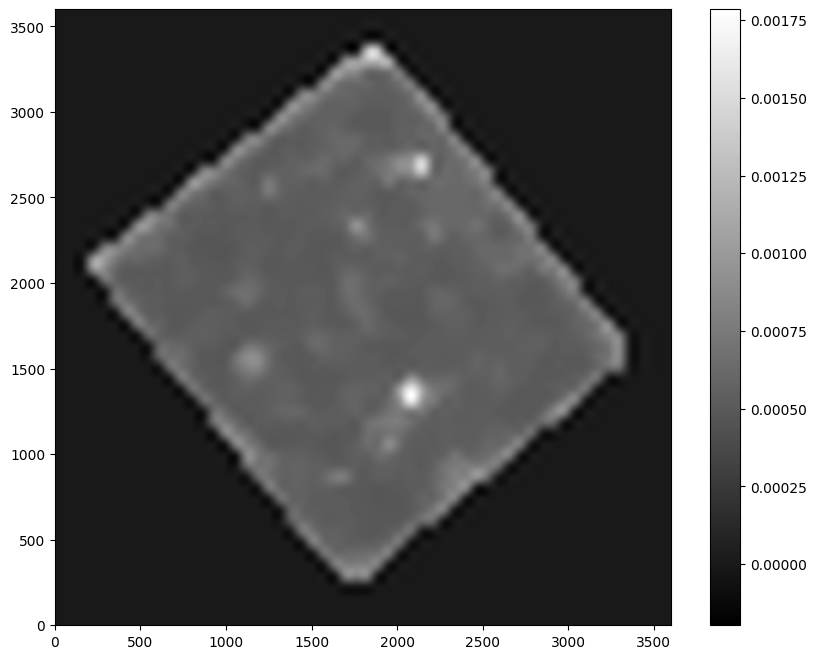

In [12]:
#show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

#plt.savefig("final-3.png", bbox_inches="tight", facecolor="white")

In [13]:
# subtract the background
data_sub = data - bkg

In [14]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [15]:
#how many objects were detected
len(objects)

8640

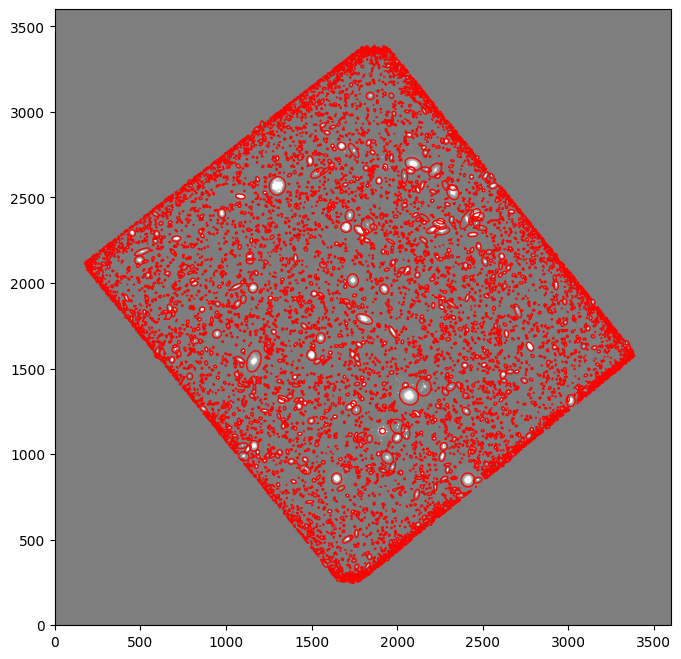

In [16]:
from matplotlib.patches import Ellipse

#plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

#plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]), 
                width=6*objects['a'][i], height=6*objects['b'][i],
                angle=objects['theta'][i] * 180 / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

#plt.savefig("final-4.png", bbox_inches="tight", facecolor="white")

In [17]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

In [18]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)
#flux, fluxerr, and flag are all 1-d arrays with one entry per object

In [19]:
# show the first 10 objects results:
for i in range (10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


/var/folders/8y/f8x9gc9515dbc2yp2y_phg8r0000gn/T/ipykernel_14752/4279497843.py:3: RuntimeWarning: invalid value encountered in log10
  x = np.log10(flux) # the data


Text(0.5, 0, 'x')

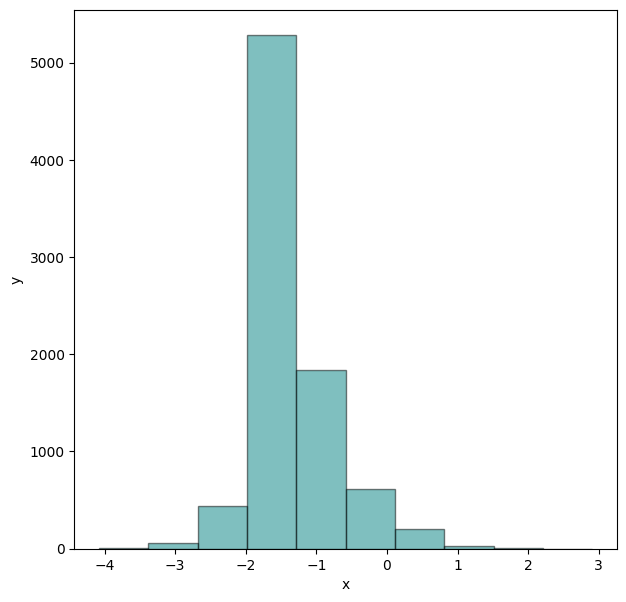

In [20]:
## creating histogram code
n = 1000 # number of random data points
x = np.log10(flux) # the data

a = 3
b = 2.5
c = 2
d = -0.4
pi = np.pi
sin = np.sin

f, ax = plt.subplots(1,1,figsize=(7,7))
f = (a*sin(b*pi*x)+c+c*sin(d*x)+np.cos(d*x))

## creating the histograms
width = 0.5
histmin = np.floor(min(x))
histmax = np.ceil(max(x))+width

ax.hist(x, bins=10, edgecolor='black', alpha=0.5, color='teal')
#bins = np.arange(histmin,histmax,width)

## labels
plt.ylabel("y")
plt.xlabel("x")
#error occurs from negative light that is not possible

In [21]:
#standard deviation
std_x = np.std(flux)

#mean
mean_x = np.mean(flux)

#median
median_x = np.median(flux)

print(f'the standard deviation is {std_x}')

print(f'the mean is {mean_x}')

print(f'the median is {median_x}')

the standard deviation is 9.243527842776762
the mean is 0.36186200071901703
the median is 0.030956558069156016


In [22]:
print(f'The outlier is {std_x - mean_x} deviations away from the mean')

The outlier is 8.881665842057746 deviations away from the mean


In [23]:
## making a 3-color image
# define file names - RGB
fdata_f160w = "hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits" #redest
fdata_f125w = "hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits" #in between
fdata_f105w = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits" #bluest


# read in data
#hdu_2 = fits.open(fdata_f105w)
#hdu_3 = fits.open(fdata_f160w)
#hdu_4 = fits.open(fdata_f125w)

#get the image data
data_2 = fits.getdata(fdata_f160w)
data_3 = fits.getdata(fdata_f125w)
data_4 = fits.getdata(fdata_f105w)

In [24]:
def rescale_image(data):
    pdata_tmp = data.copy()
    vplmin = m/2
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m * 100)
    pdata_tmp[pdata_tmp<vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp,vpmin,vpmax

In [25]:
def fits_quicklook(data,fnx=10,fny=10):
    f = plt.figure(figsize=(fnx,fny))
    pdata_tmp,vpmin,vpmax = rescale_image(data)
    plt.imshow(pdata_tmp,vmin=vpmin,vmax=vpmax)

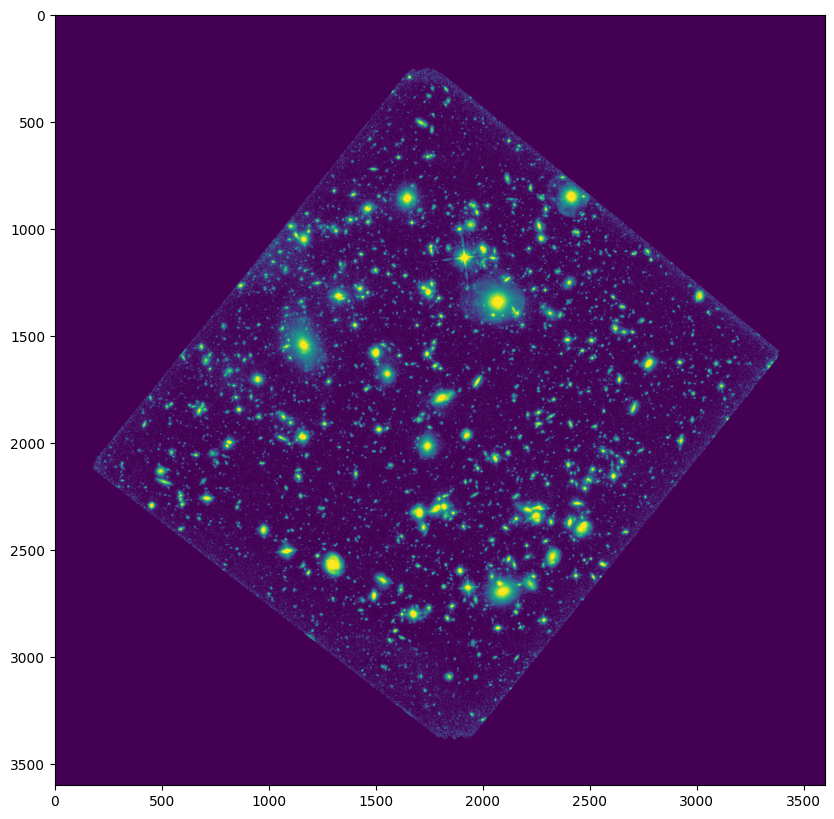

In [26]:
fits_quicklook(data_2)

In [27]:
## use the rescaled iamges
data_2_res, d2min, d2max = rescale_image(data_2)
data_3_res, d3min, d3max = rescale_image(data_3)
data_4_res, d4min, d4max = rescale_image(data_4)

In [28]:
data_2_res[data_2_res<d2min] = d2min
data_2_res[data_2_res>d2max] = d2max

data_3_res[data_3_res<d3min] = d3min
data_3_res[data_3_res>d3max] = d3max

data_4_res[data_4_res<d2min] = d4min
data_4_res[data_4_res>d2max] = d4max

In [29]:
rgb = np.zeros((data_2_res.shape[0], data_2_res.shape[1],3))
rgb[:,:,0] = (data_2_res-d2min)/(d2max-d2min)
rgb[:,:,1] = (data_3_res-d3min)/(d3max-d3min)
rgb[:,:,2] = (data_4_res-d4min)/(d4max-d4min)

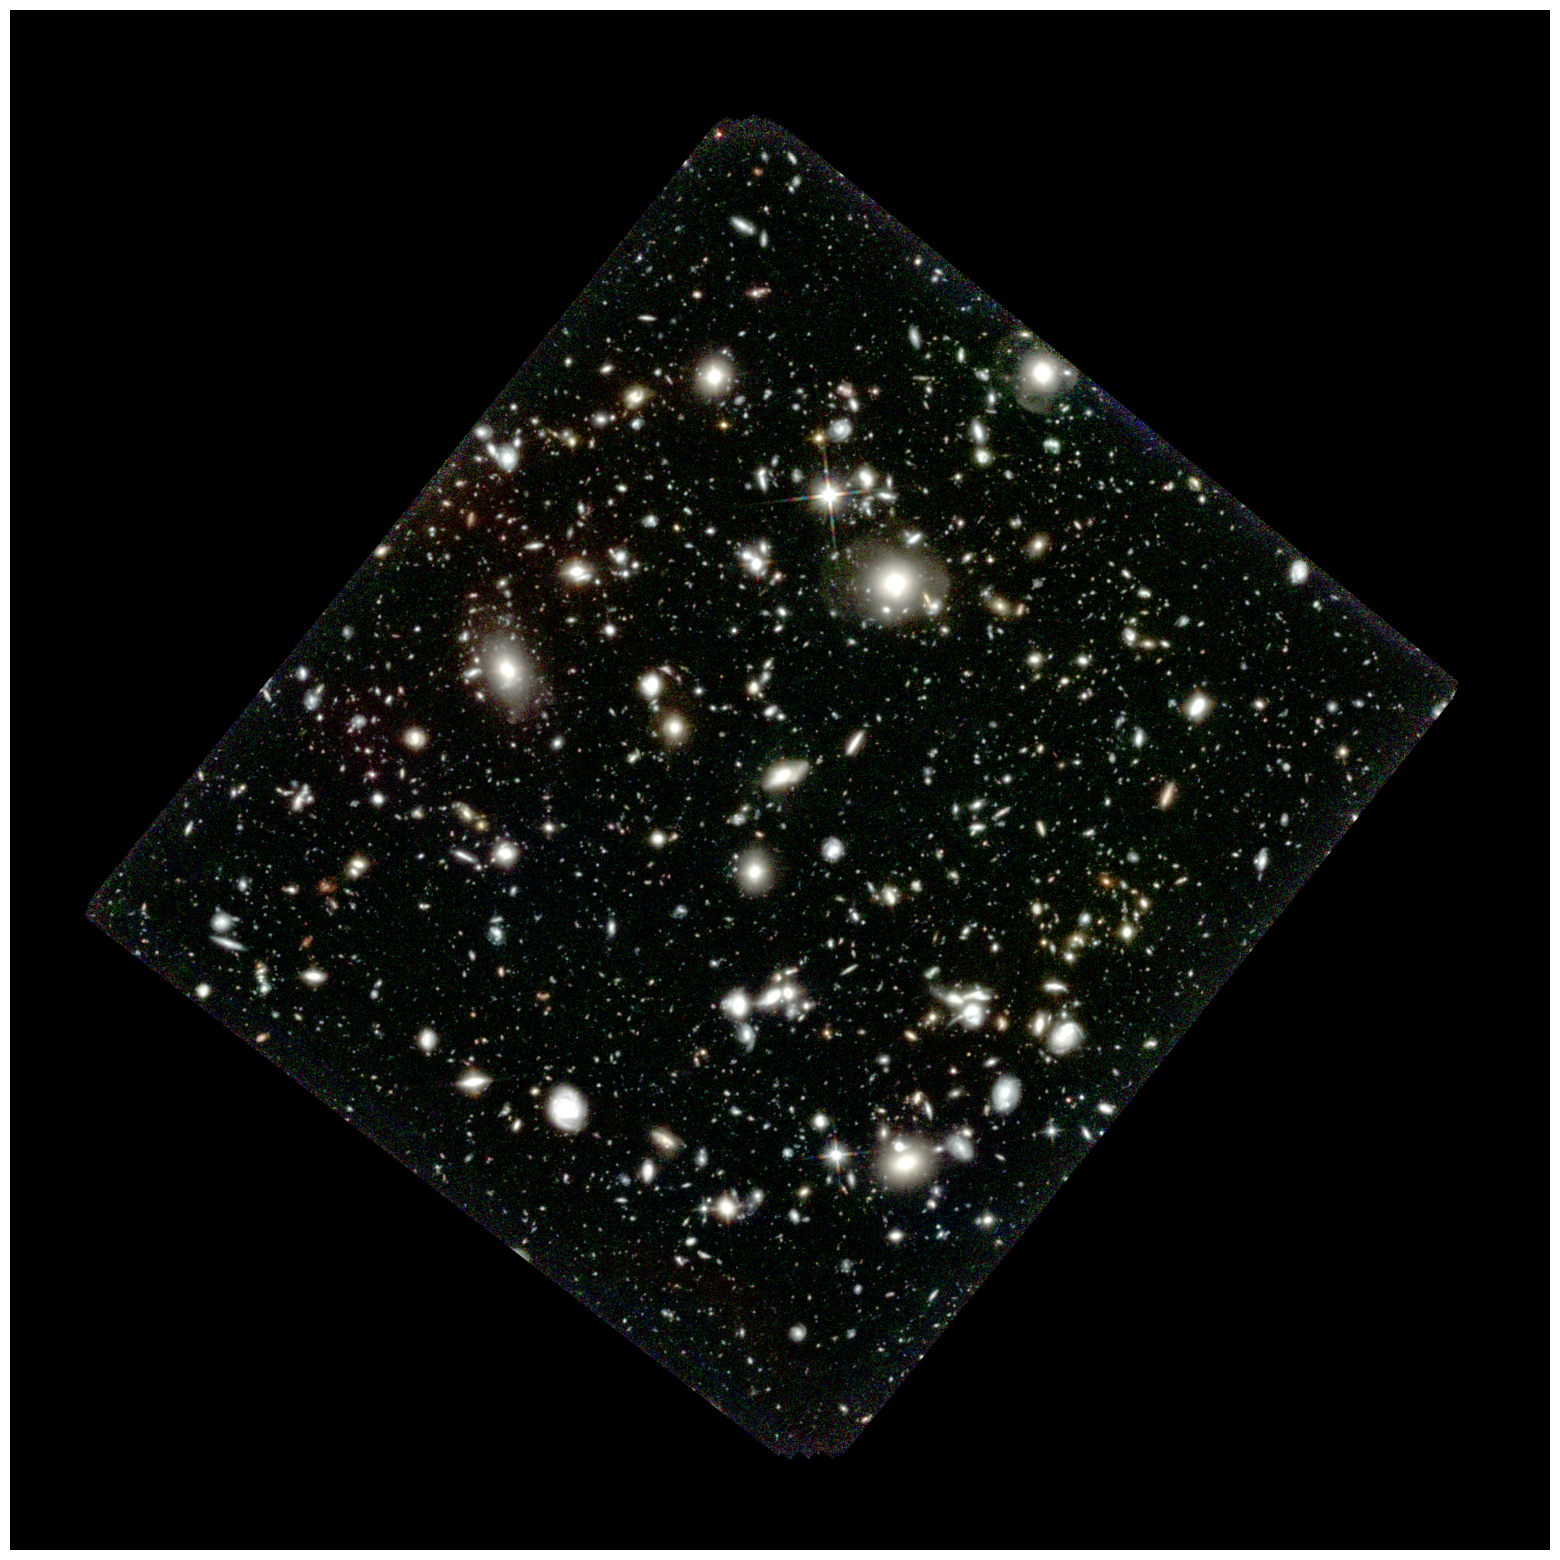

In [32]:
f, ax = plt.subplots(1,1,figsize=(20,20))
ax.axis('off')
ax.imshow(rgb)

plt.savefig('finalproject.png',bbox_inches='tight',pad_inches=0,dpi=600)